<a href="https://colab.research.google.com/github/Jagoda222/HCML_2/blob/main/ID_Jaco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intersectional Divergence try 1
This is to see whether we can use the code provided by the researchers that produced the paper on Intersectional Divergence (ID).

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [3]:
!pip install iron


In [5]:
!ls /usr/local/lib/python3.11/dist-packages/iron/


cli.py	     decorators.py  io.py     __pycache__  utils.py
commands.py  exceptions.py  lib       registry.py  watchers.py
core.py      __init__.py    local.py  runtime.py


In [6]:
!grep -ri "phi" /usr/local/lib/python3.11/dist-packages/iron/


In [7]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

def phi_control(y: pd.Series):
    """Estimate control points for the relevance function ϕ based on boxplot stats. >> five boxplot 'boundries' """
    y = y.sort_values()
    q1 = y.quantile(0.25)
    q2 = y.quantile(0.50)
    q3 = y.quantile(0.75)
    iqr = q3 - q1
    min_ = max(y.min(), q1 - 1.5 * iqr)
    max_ = min(y.max(), q3 + 1.5 * iqr)

    return {
        min_: 1.0,    # lowe boundary
        q1: 0.0,      #At the quartiles and median, relevance is 0
        q2: 0.0,
        q3: 0.0,
        max_: 1.0     # higehr boundary
    }

def phi(y: pd.Series, control_points: dict):
    """Apply the relevance function using control points from phi_control."""
    # boxplots boundries
    xs = np.array(sorted(control_points.keys()))
    # [1.0, 0.0, 0.0, 0.0, 1.0]
    ys = np.array([control_points[x] for x in xs])
    # interpolates the values
    interpolator = interp1d(xs, ys, bounds_error=False, fill_value=(ys[0], ys[-1]))
    return interpolator(y)


In [18]:
# Test
y = pd.Series([50, 55, 60, 65, 70, 80, 90, 100, 150, 200])


In [14]:
ph = phi_control(y)

phi_trues = phi(y, ph)


In [16]:
print("Target values (y):")
print(y.to_list())

print("\nControl points (from phi_control):")
print(ph)

print("\nRelevance scores (ϕ(y)):")
print(np.round(phi_trues, 3))


Target values (y):
[50, 55, 60, 65, 70, 80, 90, 100, 150, 200]

Control points (from phi_control):
{50: 1.0, np.float64(61.25): 0.0, np.float64(75.0): 0.0, np.float64(97.5): 0.0, np.float64(151.875): 1.0}

Relevance scores (ϕ(y)):
[1.    0.556 0.111 0.    0.    0.    0.    0.046 0.966 1.   ]


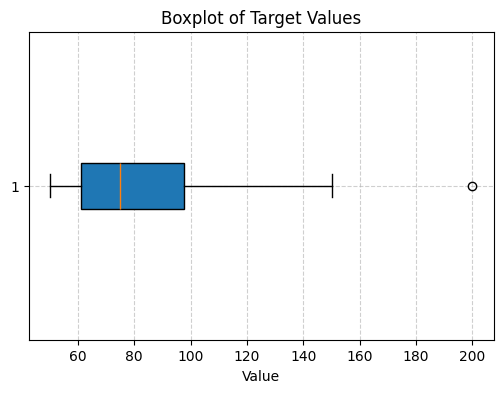

In [17]:
plt.figure(figsize=(6, 4))
box = plt.boxplot(y, vert=False, patch_artist=True)

# Add titles and labels
plt.title('Boxplot of Target Values')
plt.xlabel('Value')

# Show grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

In [8]:
def _get_relevances(y_train: pd.Series):
    ph = phi_control(y_train)
    phi_trues = np.array(phi(y_train, ph), dtype=np.float64)
    return ph, phi_trues


### Data

In [ ]:
# load data
data = pd.read_csv("adult_reconstruction.csv")
print("Data loaded")

In [ ]:
print(data.head())

In [ ]:
# checking for missing values
# for col in data:
#     print(col)
#     print(data[col].unique()) # native-country and occupation contain '?'

# print(data['native-country'].value_counts()) # 859 question marks
# print(data['occupation'].value_counts()) # 2869 question marks

before = len(data)
print(before)

# drop all rows with '?' at either native-country or occupation
data = data.drop(data[data['native-country'] == '?'].index)
data = data.drop(data[data['occupation'] == '?'].index)

print(len(data))
print("So dropped values are:", before-len(data))

### Getting the ID loss function

> Add blockquote



### Simple regression model on data

In [ ]:
# split data with 80-20 train-testsplit
# X = data.drop(columns=['income'])
# y = data['income']
# print(y)

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )
cat_features = ['workclass', 'education', 'marital-status', 'relationship', 'race', 'gender', 'native-country', 'occupation']

encoded_df = data.copy()  # Use .copy() to avoid the warning
label_encoder = LabelEncoder()

for i in cat_features:
    encoded_df.loc[:, i] = label_encoder.fit_transform(encoded_df[i])
# print(encoded_df.head())

features = list(encoded_df.columns)
features.remove('income')

train_set, test_set = train_test_split(encoded_df, test_size=0.2)

X_train = np.array(train_set[features])
y_train = np.array(train_set['income'])

X_test = np.array(test_set[features])
y_test = np.array(test_set['income'])

print(X_train)

print(y_train)

#### Linear

In [ ]:
mod = LinearRegression().fit(X_train, y_train)
y_pred = mod.predict(X_test)

#### XGBoost

## ID metric

In [ ]:
from ID import id
# id(trues: pd.Series, preds: pd.Series, X: pd.DataFrame, prot_attrs: list, pl: bool=False, return_errs: bool = False, ph=None, phi_trues=None):
print(id(y_test, y_pred, encoded_df, ['rece, gender, native_country']))